In [1]:
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import keras 
from tensorflow.keras.models import model_from_json
import glob
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
def check_dicom(filename): 
    """
    Function loading and reading DICOM file, checking relevant metadata and 
    returning numpy array containing pixels intenisties.
    
    Args:
        filename (str): name of the file to be checked.
        
    Returns:
        img (numpy array): array containing pixels intenisties.
    """
    
    print('Load file {} ...'.format(filename))
    dicom = pydicom.dcmread(filename)   
    if (dicom.Modality == 'DX') and (dicom.PatientPosition in ['AP', 'PA']) and (dicom.BodyPartExamined == 'CHEST'):
            img = dicom.pixel_array
            return img

    else:
        print('This file does not meet the requirements of chest X-ray scan in PA or AP viewing position')
    

    
def preprocess_image(img,img_mean,img_std,img_size):
    """
    Function standarizing and resizing image for model input.
    
    Args:
        img (numpy array): array containing pixels intenisties.
        img_mean (float): mean of sample batch of training data defined in the "Build and train model" part.
        img_std (float): standard deviation of sample batch of training data defined in the "Build and train model" part.
        img_size (tuple of int): tuple containing input size.
        
    Returns:
        proc_img (numpy array): array containing standarized pixel intensities.
    """
        
    
    proc_img = (img - img_mean) / img_std
    proc_img = np.resize(proc_img, img_size)

    return proc_img

                                     

def load_model(model_path, weight_path):
    """
    Function loading trained model together with its weights and compiling it.
    
    Args:
        model_path (str): path to .json file containing the model.
        weight_path (str): path to .hdf5 file containing the model's weights

    Returns:
        model(Model): complied model.
    """
        
    with open(model_path, 'r') as json_file:
        model = json_file.read()
        model= model_from_json(model)
        model.load_weights(weight_path)
        model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics= ['binary_accuracy'])
    
    return model


def predict_image(model, proc_img, thresh): 
    """
    Function generating prediction.
    
    Args:
        model(Model): complied model.
        proc_img (numpy array): array containing standarized pixel intensities.
        tresh (float): treshold for the classification.

    Returns:
        prediction (int): prediction of the class.
    """
    
    
    pred = model.predict(proc_img)
    if pred >= thresh:
        prediction = 'Pneumonia positive'
    else:
        prediction = 'Pneumonia negative'
    
    return prediction 

Load file test1.dcm ...
Load file test2.dcm ...
Load file test3.dcm ...
Load file test4.dcm ...
This file does not meet the requirements of chest X-ray scan in PA or AP viewing position
Load file test5.dcm ...
This file does not meet the requirements of chest X-ray scan in PA or AP viewing position
Load file test6.dcm ...
This file does not meet the requirements of chest X-ray scan in PA or AP viewing position


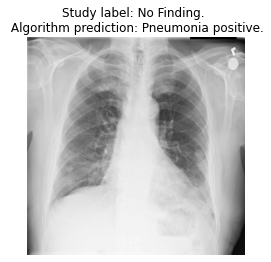

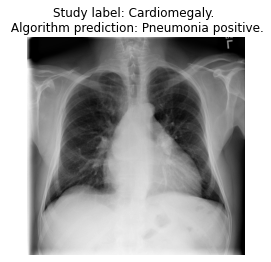

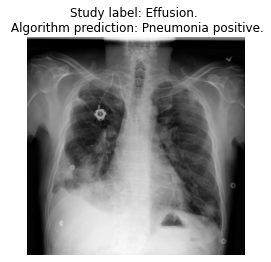

In [3]:
# Filenames of DICOM files to be tested
test_dicoms = ['test1.dcm', 'test2.dcm', 'test3.dcm', 'test4.dcm', 'test5.dcm', 'test6.dcm']

# Paths to model and its weights
model_path = 'model_4.json'
weight_path = 'model_4.best.hdf5'

# Specifing size of the model input, mean and std of sample batch of training data
IMG_SIZE=(1,224,224,3)
img_mean = np.load('Training_sample_mean.npy')
img_std = np.load('Training_sample_std.npy')

# Specifying model and treshold
my_model = load_model(model_path, weight_path)
thresh = 0.171

# Genrating predictions 
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    ground_truth = pydicom.dcmread(i).StudyDescription
    
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(label= f'Study label: {ground_truth}. \n Algorithm prediction: {pred}.')
    plt.axis('off')

In [4]:
# Checking DICOM files not fullfilling the requirements
dicom_4 = pydicom.dcmread('test4.dcm')
dicom_4

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'RIBCAGE'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows     

In [5]:
dicom_5 = pydicom.dcmread('test5.dcm')
dicom_5

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

In [6]:
dicom_6 = pydicom.dcmread('test6.dcm')
dicom_6

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'XX'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       